In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Attention, Concatenate, Multiply, Permute, RepeatVector
from keras.layers import Activation, GlobalAveragePooling1D, Reshape, Flatten, TimeDistributed
import matplotlib.pyplot as plt

In [16]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df_temp = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
df_temp

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [17]:
scaler = MinMaxScaler(feature_range = (0,1))
df_temp['Temp'] = scaler.fit_transform(df_temp[['Temp']])
df_temp

,Temp
Date,
1981-01-01,0.787072
1981-01-02,0.680608
1981-01-03,0.714829
1981-01-04,0.555133
1981-01-05,0.600760
...,...
1990-12-27,0.532319
1990-12-28,0.517110
1990-12-29,0.513308


In [18]:
def crear_secuencia(data, time_steps):
    X, y = [], []
    for i in range (len(data) - time_steps):
        X.append(data[i:(i+time_steps)])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

crear_secuencia(df_temp['Temp'].values, 5)

ventana = 3
data = df_temp['Temp'].values

X,y = crear_secuencia(data, ventana)

In [19]:
X = X.reshape((X.shape[0], X.shape[1], 1))
X

array([[[0.78707224],
        [0.68060837],
        [0.7148289 ]],

       [[0.68060837],
        [0.7148289 ],
        [0.55513308]],

       [[0.7148289 ],
        [0.55513308],
        [0.60076046]],

       ...,

       [[0.55513308],
        [0.53231939],
        [0.51711027]],

       [[0.53231939],
        [0.51711027],
        [0.51330798]],

       [[0.51711027],
        [0.51330798],
        [0.59695817]]])

In [20]:
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [21]:
def LSTM_con_atencion(ventana, caracteristicas=1):
    inputs = Input(shape=(ventana, caracteristicas))
    lstm_out = LSTM(50, activation='relu', return_sequences=True)(inputs)
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(50)(attention)
    attention = Permute([2, 1])(attention)

    pesos_lstm = Multiply()([lstm_out, attention])
    contexto_vector = GlobalAveragePooling1D()(pesos_lstm)
    output = Dense(1)(contexto_vector)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [22]:
modelo_LSTM_at = LSTM_con_atencion(ventana)
history = modelo_LSTM_at.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
92/92 [==============================] - 2s 10ms/step - loss: 0.1148 - val_loss: 0.0162
Epoch 2/20
92/92 [==============================] - 1s 16ms/step - loss: 0.0142 - val_loss: 0.0121
Epoch 3/20
92/92 [==============================] - 1s 14ms/step - loss: 0.0135 - val_loss: 0.0116
Epoch 4/20
92/92 [==============================] - 1s 15ms/step - loss: 0.0132 - val_loss: 0.0112
Epoch 5/20
92/92 [==============================] - 1s 14ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 6/20
92/92 [==============================] - 1s 14ms/step - loss: 0.0129 - val_loss: 0.0109
Epoch 7/20
92/92 [==============================] - 1s 12ms/step - loss: 0.0126 - val_loss: 0.0107
Epoch 8/20
92/92 [==============================] - 1s 10ms/step - loss: 0.0126 - val_loss: 0.0105
Epoch 9/20
92/92 [==============================] - 1s 12ms/step - loss: 0.0124 - val_loss: 0.0104
Epoch 10/20
92/92 [==============================] - 1s 14ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 11/

In [23]:
loss = modelo_LSTM_at.evaluate(X_test, y_test)
print(f'Loss: {loss}')

23/23 [==============================] - 0s 6ms/step - loss: 0.0091
Loss: 0.009119389578700066


In [24]:
y_pred = modelo_LSTM_at.predict(X_test)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_real = scaler.inverse_transform(y_pred)

23/23 [==============================] - 0s 5ms/step


In [25]:
indices_test = df_temp.index[train_size+ventana:train_size+ventana+len(y_pred_real)]
resultados = pd.DataFrame({'Fecha': indices_test,
                           'Temperatura Real': y_test_real.flatten(),
                           'Temperatura Predicción': y_pred_real.flatten()} )
resultados

,Fecha,Temperatura Real,Temperatura Predicción
0,1989-01-01,14.3,14.461798
1,1989-01-02,17.4,14.725876
2,1989-01-03,18.5,16.074911
3,1989-01-04,16.8,17.249670
4,1989-01-05,11.5,16.943047
...,...,...,...
725,1990-12-27,14.0,13.446469
726,1990-12-28,13.6,14.365299
727,1990-12-29,13.5,14.373689
728,1990-12-30,15.7,14.123529


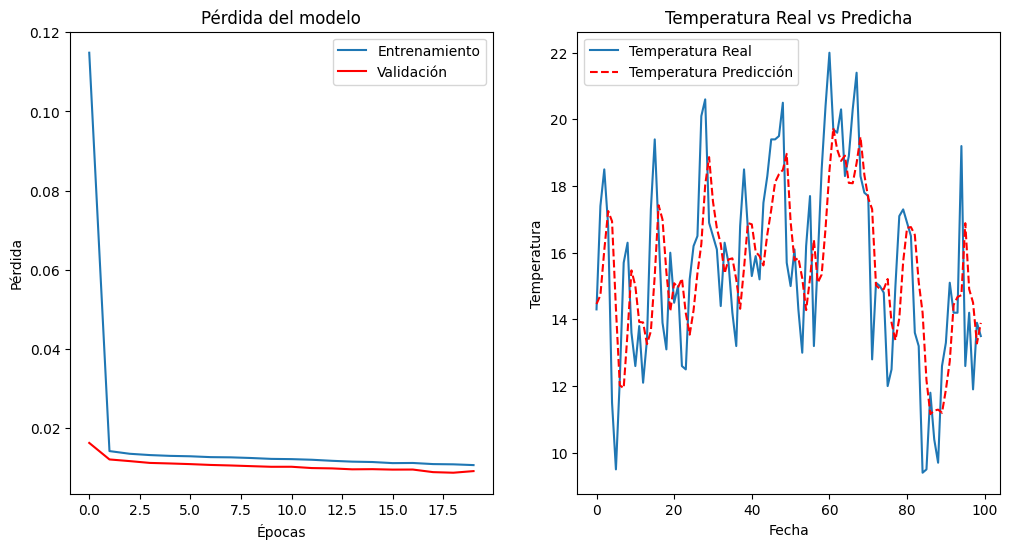

In [26]:
# Generar gráfica que genere función de pérdida y resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], 'r', label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resultados['Temperatura Real'][:100], label='Temperatura Real')
plt.plot(resultados['Temperatura Predicción'][:100], 'r--', label='Temperatura Predicción')
plt.title('Temperatura Real vs Predicha')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()